In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# import raw data
def import_data(url):
    df = pd.read_csv(url)
    return df

In [3]:
# import data
gridwatch_df = import_data("gridwatch.csv")

# change the labels
gridwatch_df = gridwatch_df.rename(columns={' timestamp':'ds', ' demand':'y'})
gridwatch_df.head()

,ds,y
0,2017-05-17 00:00:31,34971
1,2017-05-17 00:05:32,34971
2,2017-05-17 00:10:32,34971
3,2017-05-17 00:15:31,35026
4,2017-05-17 00:20:32,34716


In [4]:
gridwatch_df.y = gridwatch_df.y.astype(int)

In [5]:
# turn strings into datetime
gridwatch_df['ds'] = pd.to_datetime(gridwatch_df.iloc[:,0], format='%Y-%m-%d %H:%M:%S')

In [6]:
length = len(gridwatch_df)
length # hold test size of 60
train_size = length-60

In [7]:
# Creating train and test set, do just 10% of the data
# Index 10392 marks the end of October 2013 
train_df = gridwatch_df[: train_size] 
test_df = gridwatch_df[train_size :]

C:\Users\steve\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


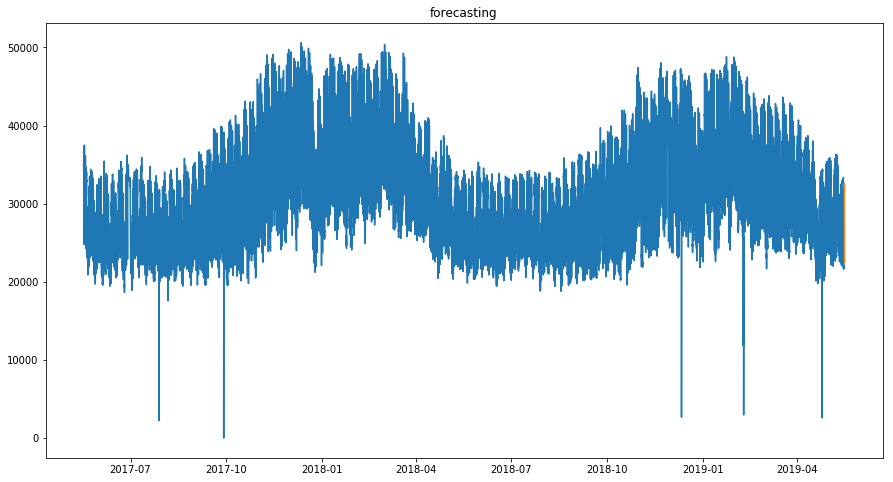

In [8]:
# plotting the actual data
plt.figure(figsize=(15,8))
plt.plot(train_df['ds'], train_df['y'])
plt.plot(test_df['ds'], test_df['y'])
plt.title('forecasting')
plt.show()

In [ ]:
# try fbprophet
import fbprophet
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [ ]:
# create instance of prophet
two_years_data = length - (6*24*30*24)
df2 = gridwatch_df[two_years_data:]
df2.reset_index(inplace=True)
df2.tail()

,index,ds,y
103675,210077,2019-05-16 23:35:33,22688
103676,210078,2019-05-16 23:40:36,22657
103677,210079,2019-05-16 23:45:36,22599
103678,210080,2019-05-16 23:50:34,22532
103679,210081,2019-05-16 23:55:34,22469


In [ ]:
# fit the data (only 1/7th of it)
# from lloking at data, we can set high cap to 55,000 and low to 15,000
# this gives us a workable range
df2['cap'] = 55000
df2['floor'] = 15000

df2_prophet = Prophet( changepoint_prior_scale=0.10, growth='logistic')
df2_prophet.add_country_holidays(country_name='UK')
df2_prophet.fit(df2)

C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
# future predicted values dataset, provides hourly predictions ahead of time
# periods will be a variable
future = df2_prophet.make_future_dataframe(periods=24, freq='H')
future['cap'] = 55000
future['floor'] = 15000
future.tail()

In [ ]:
# forecast uncertainty for future predicted points
forecast = df2_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

In [ ]:
# plot, black dots are actual points. blue ine is prediction
df2_prophet.plot(forecast, xlabel='date', ylabel='consumption (kWH)')

In [ ]:
df2_prophet.plot_components(forecast)

In [ ]:
# now for evaluating our model
from fbprophet.diagnostics import cross_validation

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''Take in True and Predicted and calculate the mean av percentage score'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [ ]:
# predicting in hourly periods because of hourly data
cv_results = cross_validation(df2_prophet, initial='1500 hours', period='23 hours', horizon='400 hours')

In [ ]:
# calculating Mininmum absolute percentage error (MAPE)
mape_baseline = mean_absolute_percentage_error(cv_results.y, cv_results.yhat)

In [ ]:
## To get the right future data, look at the forecast and predict
# output over next 24 hour period with uncertainties